# 2D Case

In [1]:
from core.runner import Runner
import tensorflow as tf

grid_dim = 2
grid_length = 8

runner = Runner(
    grid_dimension=grid_dim, grid_length=grid_length,
    main_layer_hidden_nodes=[30, 20],
    branch1_hidden_nodes=[10],
    branch2_hidden_nodes=[10],
    exploration_rate=0.5,
    learning_rate=0.0005
)

2022-12-07 11:49:03.712098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import time

batch_size = tf.constant(500)
n_iterations = tf.constant(int(1e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 11.0757008
Iteration: 1000 Average Loss: 2.35838366
Iteration: 2000 Average Loss: 1.60693336
Iteration: 3000 Average Loss: 1.02539337
Iteration: 4000 Average Loss: 0.559286475
Iteration: 5000 Average Loss: 0.237496018
Iteration: 6000 Average Loss: 0.107736617
Iteration: 7000 Average Loss: 0.0252121016
Iteration: 8000 Average Loss: 0.00304357824
Iteration: 9000 Average Loss: 0.000116867421
Time Elapsed: 396.2505569458008 s


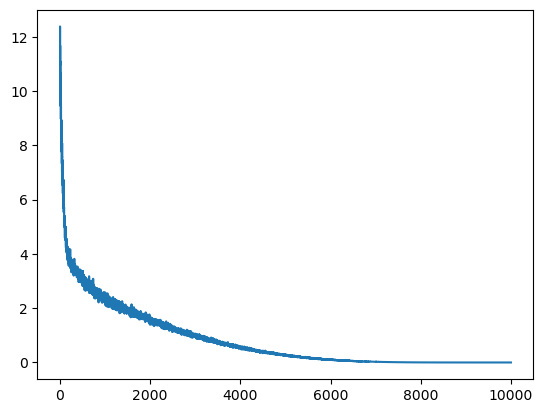

In [3]:
import matplotlib.pyplot as plt

plt.plot(ave_losses.numpy())

# Continue Training

Iteration: 0 Average Loss: 3.33287517e-06
Iteration: 1000 Average Loss: 1.96880208e-07
Iteration: 2000 Average Loss: 5.0726095e-07
Iteration: 3000 Average Loss: 8.80434618e-06
Iteration: 4000 Average Loss: 5.14805905e-08
Iteration: 5000 Average Loss: 2.16652224e-05
Iteration: 6000 Average Loss: 3.81775908e-06
Iteration: 7000 Average Loss: 3.82091275e-06
Iteration: 8000 Average Loss: 0.000111521185
Iteration: 9000 Average Loss: 1.00430475e-09
Iteration: 10000 Average Loss: 4.05746641e-06
Iteration: 11000 Average Loss: 2.12892246e-06
Iteration: 12000 Average Loss: 4.76991263e-05
Iteration: 13000 Average Loss: 6.84952706e-10
Iteration: 14000 Average Loss: 5.54138033e-08
Time Elapsed: 528.7723278999329 s


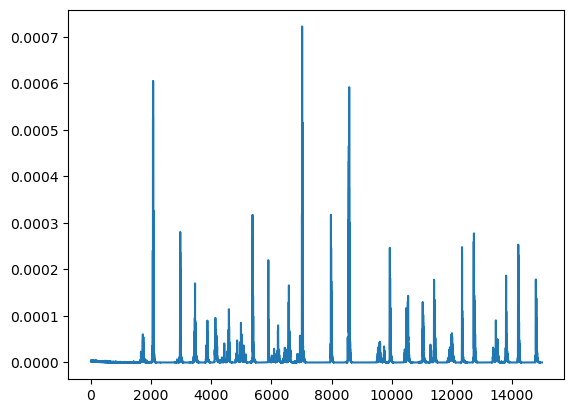

In [4]:
batch_size = tf.constant(500)
n_iterations = tf.constant(int(1.5e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

plt.plot(ave_losses.numpy())

In [5]:
batch_size = tf.constant(5000)

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

agent_distr

Percentage of coordinates sampled uniquely: 39.06%


<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.0528, 0.0516, 0.    , 0.    , 0.    , 0.0002, 0.047 , 0.0536],
       [0.053 , 0.1064, 0.0002, 0.    , 0.    , 0.    , 0.0922, 0.0486],
       [0.    , 0.0002, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0002, 0.    , 0.    , 0.0002, 0.    , 0.    , 0.0002, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0002, 0.    , 0.    , 0.    , 0.    , 0.0004],
       [0.0458, 0.1   , 0.    , 0.    , 0.0002, 0.    , 0.0962, 0.0526],
       [0.0506, 0.048 , 0.    , 0.    , 0.    , 0.    , 0.0542, 0.0454]],
      dtype=float32)>

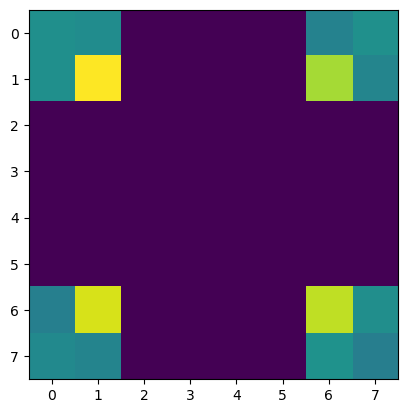

In [6]:
plt.imshow(agent_distr.numpy())

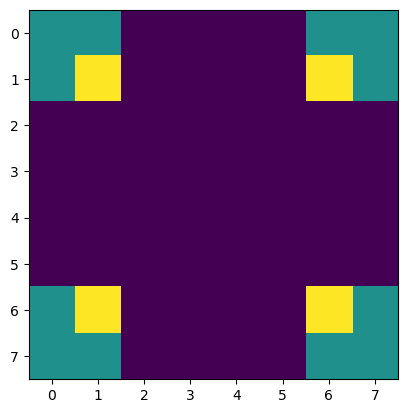

In [7]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

plt.imshow(env_distr.numpy())

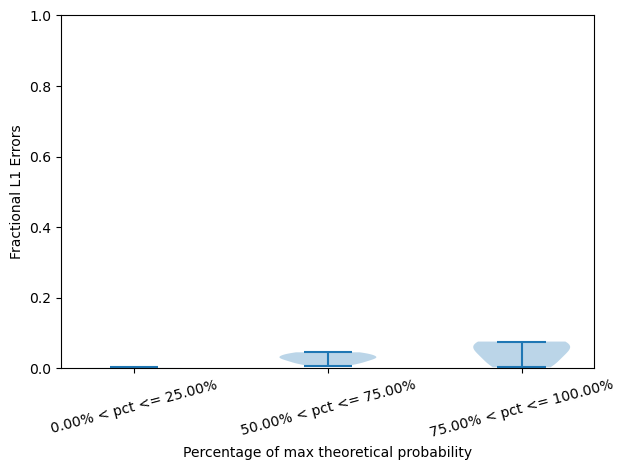

In [8]:
import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

    frac_l1_errors = np.abs(result - expected) / max_expected
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
        errors_per_interval = frac_l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            errors.append(errors_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots()
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

# 5D Case

In [31]:
grid_dim = 5
grid_length = 8

runner = Runner(
    grid_dimension=grid_dim, grid_length=grid_length,
    main_layer_hidden_nodes=[80, 40, 20],
    branch1_hidden_nodes=[10],
    branch2_hidden_nodes=[10],
    exploration_rate=0.5,
    learning_rate=0.0005
)

In [32]:
batch_size = tf.constant(500)
n_iterations = tf.constant(int(3.5e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 53.7884903
Iteration: 1000 Average Loss: 12.2109632
Iteration: 2000 Average Loss: 9.50178719
Iteration: 3000 Average Loss: 7.34256124
Iteration: 4000 Average Loss: 5.76831341
Iteration: 5000 Average Loss: 4.56759882
Iteration: 6000 Average Loss: 3.33857918
Iteration: 7000 Average Loss: 2.17699027
Iteration: 8000 Average Loss: 1.50926805
Iteration: 9000 Average Loss: 1.10871
Iteration: 10000 Average Loss: 0.715801418
Iteration: 11000 Average Loss: 0.650768578
Iteration: 12000 Average Loss: 0.365222842
Iteration: 13000 Average Loss: 0.329690725
Iteration: 14000 Average Loss: 0.214894101
Iteration: 15000 Average Loss: 0.169397801
Iteration: 16000 Average Loss: 0.0879052356
Iteration: 17000 Average Loss: 0.0555294342
Iteration: 18000 Average Loss: 0.0271040983
Iteration: 19000 Average Loss: 0.0141106341
Iteration: 20000 Average Loss: 0.0149513735
Iteration: 21000 Average Loss: 0.0133248921
Iteration: 22000 Average Loss: 0.00991444569
Iteration: 23000 Average Loss

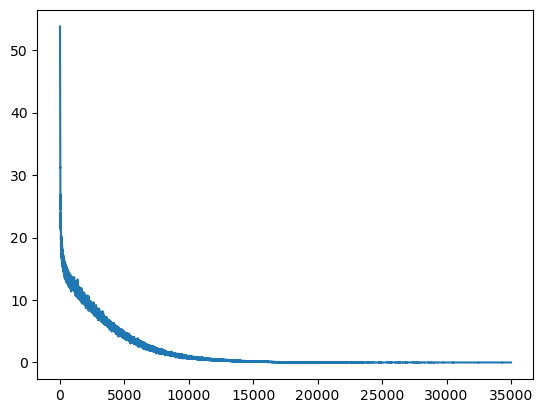

In [33]:
plt.plot(ave_losses.numpy())

In [34]:
# batch_size = tf.constant(int((grid_length ** grid_dim) * 100))
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 7.51%


In [35]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

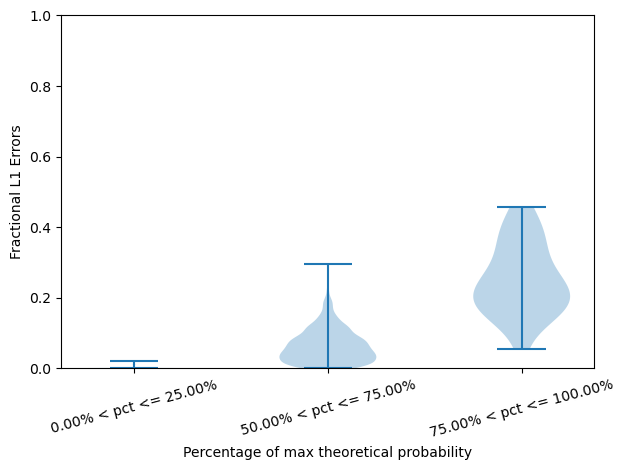

In [36]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [37]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 39.33%


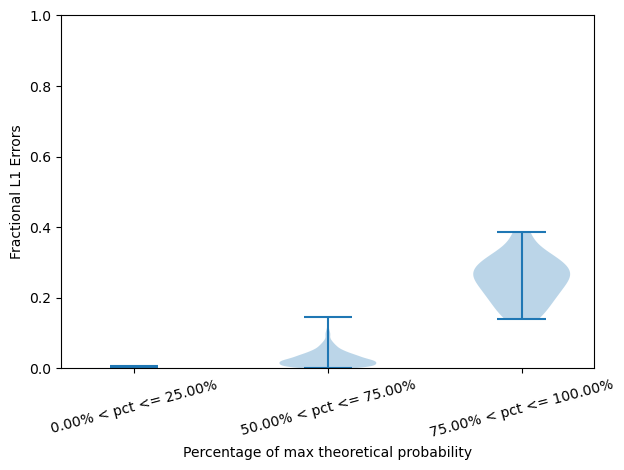

In [38]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

# Continue training

Iteration: 0 Average Loss: 0.00392136071
Iteration: 1000 Average Loss: 0.00286604813
Iteration: 2000 Average Loss: 0.00258166785
Iteration: 3000 Average Loss: 0.00212275
Iteration: 4000 Average Loss: 0.00306620449
Iteration: 5000 Average Loss: 0.00198702374
Iteration: 6000 Average Loss: 0.00221934798
Iteration: 7000 Average Loss: 0.00198664749
Iteration: 8000 Average Loss: 0.00165868737
Iteration: 9000 Average Loss: 0.00160076877
Iteration: 10000 Average Loss: 0.00201226654
Iteration: 11000 Average Loss: 0.00191810459
Iteration: 12000 Average Loss: 0.00132538786
Iteration: 13000 Average Loss: 0.0016924378
Iteration: 14000 Average Loss: 0.00174870028
Iteration: 15000 Average Loss: 0.0015236754
Iteration: 16000 Average Loss: 0.00188353611
Iteration: 17000 Average Loss: 0.00120660115
Iteration: 18000 Average Loss: 0.00155853631
Iteration: 19000 Average Loss: 0.00270514097
Iteration: 20000 Average Loss: 0.00152841851
Iteration: 21000 Average Loss: 0.00131639186
Iteration: 22000 Average Los

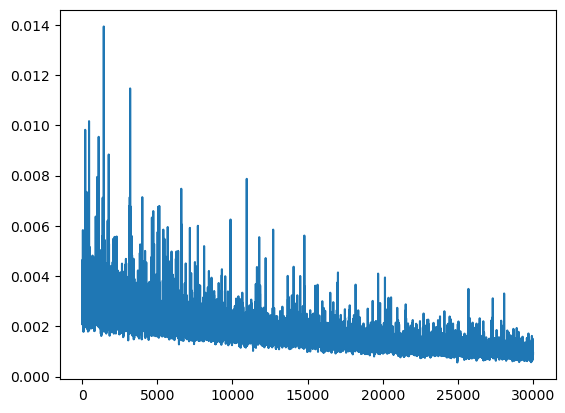

In [39]:
batch_size = tf.constant(500)
n_iterations = tf.constant(int(3e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

plt.plot(ave_losses.numpy())

In [40]:
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 7.27%


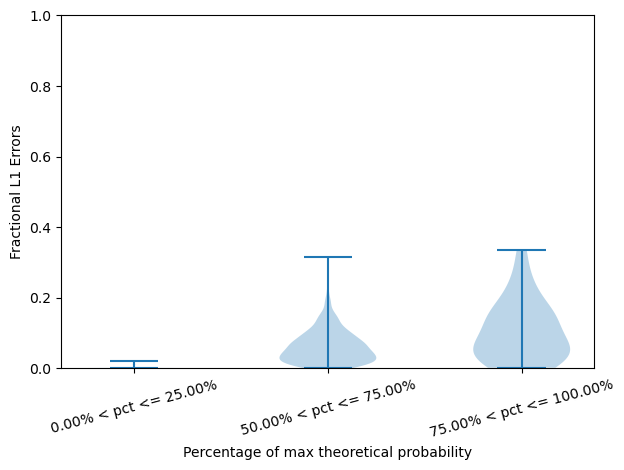

In [41]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [42]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 38.68%


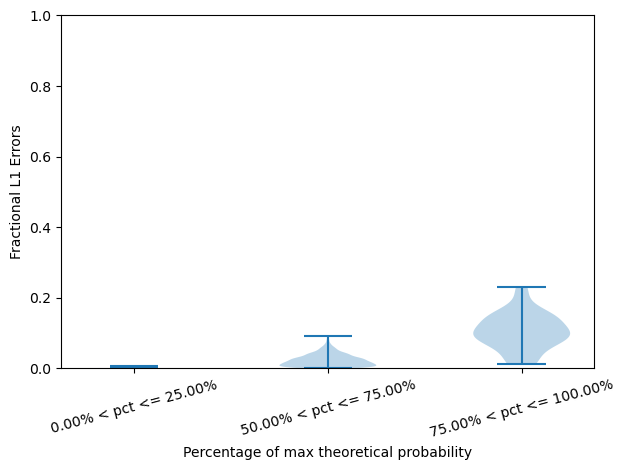

In [43]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

Iteration: 0 Average Loss: 0.000842266832
Iteration: 1000 Average Loss: 0.000782635936
Iteration: 2000 Average Loss: 0.000654832693
Iteration: 3000 Average Loss: 0.000625566696
Iteration: 4000 Average Loss: 0.000696642848
Iteration: 5000 Average Loss: 0.000715069822
Iteration: 6000 Average Loss: 0.000514737
Iteration: 7000 Average Loss: 0.000580141
Iteration: 8000 Average Loss: 0.000640064594
Iteration: 9000 Average Loss: 0.000629164337
Time Elapsed: 3208.134793996811 s


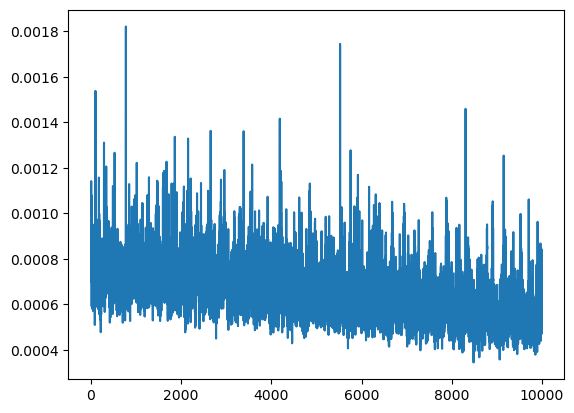

In [44]:
batch_size = tf.constant(1000)
n_iterations = tf.constant(int(1e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

plt.plot(ave_losses.numpy())

In [45]:
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 7.51%


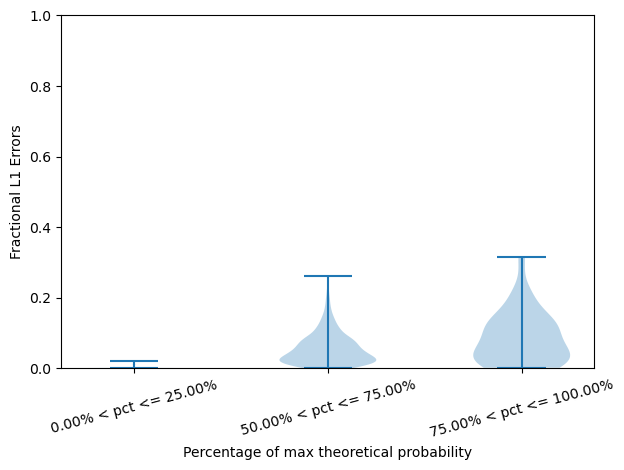

In [46]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [47]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 39.01%


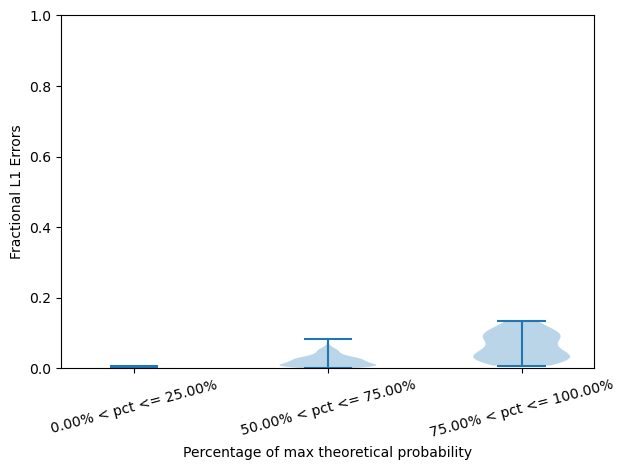

In [48]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)